# Traffic Sign Recognition using a CNN

### Classification
One of the most common use case when doing image recognition is what we call classification. Basically, when presented with a picture, the algorithm should be able to tell what the picture represent, give it one (or several) **label**.

### Traffic Sign Recognition
One subclass of problem is the recognition of traffic signs on the roads. I do not have to explain that this has been (and still is) a very important research topic (see the self-driving car )

<img src="https://www.seton.net.au/media/catalog/product/cache/1/small_image/280x280/9df78eab33525d08d6e5fb8d27136e95/a/3/a34046.jpg" width="200">

Using a convolutional neural network, I'll try here to do a very basic classification, basically train a network to detect if the picture represent a traffic sign or not. 

### Setup
I am using this data for this [Reference Data](http://parse.ele.tue.nl/research/speedsign/) from the university of Eindhoven in the Netherlands as it is already processed to a nice format (save us some time in image processing), and the dataset is relatively small (which suits my not all too powerfull GPU ... more about that below).

We'll be using [TensorFlow](https://www.tensorflow.org/) on a GPU as back-end (NVidia with [CUDA/cuDNN](https://developer.nvidia.com/cuda-downloads) support, unfortunately only 2GB of RAM) and [Keras](https://keras.io/) on top of it to simplify the wiring. I'll leave it to the reader to install all of this. While the installation process has been getting better over the years, it is still cumbersone enough that it would take a whole notebook just to explain it!

## Loading the libraries

In [1]:
## Loading the libraries
import numpy
import scipy.io as sio
from scipy import misc
from scipy.misc import toimage
import numpy as np
import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

Using TensorFlow backend.


Checking that the GPU is enabled. In the jupyter standard output log, the following line indicates that the GPU has correctly been found and identified.

```
I c:\tf_jenkins\home\workspace\release-win\device\gpu\os\windows\tensorflow\core\common_runtime\gpu\gpu_device.cc:885] Found device 0 with properties:
name: Quadro K2100M
major: 3 minor: 0 memoryClockRate (GHz) 0.6665
pciBusID 0000:01:00.0
Total memory: 2.00GiB
Free memory: 1.66GiB
```

# Load the matlab dataset

In [2]:
data = sio.loadmat("speedsigndataset.mat")

# Split in train and test data
X_train_raw = data["trainset"] 
y_train_raw = data["classtrainset"] 
X_test_raw = data["testset"] 
y_test_raw = data["classtestset"] 

### What's the shape of the data set

In [3]:
X_train_raw.shape

(32, 32, 3100)

The shape will need to be changed to fit the model

## What's in the dataset

The training data is made of b&w pictures (32 x 32 pixels), let's have a look to get a feeling of the content of the dataset. Always a good starting point when working with pictures.

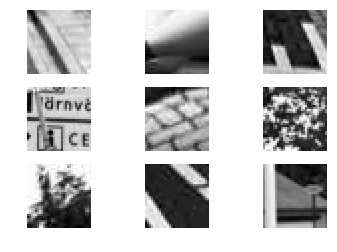

In [4]:
X_train_photo = numpy.rollaxis(X_train_raw,2,0)

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    plt.imshow(toimage(X_train_photo[i]), cmap=plt.cm.gray)
plt.show()


There are 2 labelling schemes in the label array as described in the table below (column output label). We are interesting only in the first one here, whether a picture is a traffic sign or not.(it would be easy to train a model to actually identify the speed limits)


![alt text](dataTable.png "Labels structure")


## Format the dataset to match the requested CNN input format

In [5]:
# roll the axes to have the row length being the first parameter
X_train_rolled = numpy.rollaxis(X_train_raw,2,0)

# CNN accepts tensors of dimension 4 as input, so we need to add an extra dimension
X_train = X_train_rolled.reshape(X_train_rolled.shape + (1,)).astype('float32') / 255

# do the same for the test set
X_test_rolled = numpy.rollaxis(X_test_raw,2,0)
X_test = X_test_rolled.reshape(X_test_rolled.shape + (1,)).astype('float32') / 255


print("Shape of X_train: {0}, Shape of X_test: {1} ".format(X_train.shape, X_test.shape) )

Shape of X_train: (3100, 32, 32, 1), Shape of X_test: (517, 32, 32, 1) 


Images are here already normalized between 0 and 1. When using RGB pictures for example, first normalizing them might improve the performance of the neural network.

### And now the labels

We are only interested in the first columns

In [6]:
y_train_rolled = numpy.rollaxis(y_train_raw, 1, 0)
y_test_rolled = numpy.rollaxis(y_test_raw, 1, 0)

# Here the classes scheme is changed in a categorical scheme. 2 columns representing the 0 and 1, 
# a 1 is present when the column is selected, otherwise a 0.
y_train = np_utils.to_categorical(y_train_rolled[:,0:1])
y_test = np_utils.to_categorical(y_test_rolled[:,0:1])
num_classes = y_test.shape[1]

print("Shape of y_train: {0}, Shape of y_test: {1} ".format(y_train.shape, y_test.shape ))

Shape of y_train: (3100, 2), Shape of y_test: (517, 2) 


# Deep Neural Network

### Define the network

The model is a simple model with 2 convolutional layers and 2 dense layers, the first 3 have a relu activation and the latest a softmax.
Dropout and Maxpooling are applied to improve the overall performance of the network.


In [7]:
# Create the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 1), padding='same', activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_constraint=maxnorm(3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

### Train the network

In [8]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 3100 samples, validate on 517 samples
Epoch 1/25
3100/3100 [==============================] - 6s - loss: 0.3669 - acc: 0.8542 - val_loss: 0.3510 - val_acc: 0.9130
Epoch 2/25
3100/3100 [==============================] - 5s - loss: 0.1708 - acc: 0.9439 - val_loss: 0.1689 - val_acc: 0.9439
Epoch 3/25
3100/3100 [==============================] - 5s - loss: 0.1060 - acc: 0.9606 - val_loss: 0.0963 - val_acc: 0.9536
Epoch 4/25
3100/3100 [==============================] - 5s - loss: 0.0750 - acc: 0.9745 - val_loss: 0.0703 - val_acc: 0.9671
Epoch 5/25
3100/3100 [==============================] - 5s - loss: 0.0524 - acc: 0.9832 - val_loss: 0.0631 - val_acc: 0.9729
Epoch 6/25
3100/3100 [==============================] - 5s - loss: 0.0461 - acc: 0.9829 - val_loss: 0.0476 - val_acc: 0.9807
Epoch 7/25
3100/3100 [==============================] - 5s - loss: 0.0352 - acc: 0.9858 - val_loss: 0.0460 - val_acc: 0.9826
Epoch 8/25
3100/3100 [==============================] - 5s - loss: 0.0280 - ac

**This went well !!**

To summarize: 
* \> 4 millions parameters to train on !!
* 5s per epoch (this is where the GPU comes in handy :0))

Accuracy **99.61%** is quite impressive, of 3000 pictures it gets on average a bit more than 1 picture wrong!


The network has been trained and is now saved into a file so we don't have to retrain it everytime we want to use.

In [9]:
# now we save the model, so we don't have to do the training all over again
model.save('eindhoven-model.h5')

In [ ]:
# loading the weights if we don't want to retrain the model
model.load_weights('eindhoven-model.h5')

Let's just get a quick look in the data to get a feeling of what the algorithm is doing.

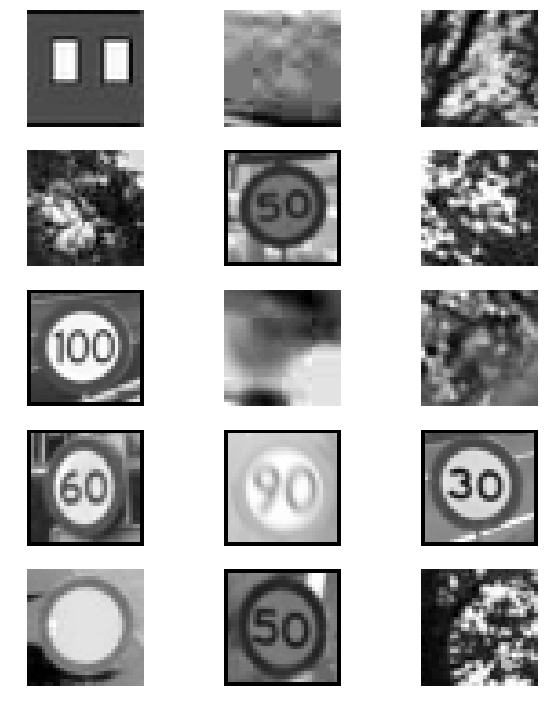

In [26]:
from random import seed
from random import randint
seed(1241251) # so we always get the same number

# parameters for image display
numcols = 3
numrows = 6

from pylab import rcParams
rcParams['figure.figsize'] = 10, 15

# we start at index 90, and show 1 out of every 15 pictures
pictureCount = 15;

prediction = model.predict(X_test)

for i in range(0,pictureCount):
    
    index = randint(0, len(X_test)) 
    
    image = np.copy(X_test[index].reshape(32,32)) * 255
    
    # if prediction is 1, add a black border to the picture
    
    if prediction[index][1] > 0.5:
        image[0:1] = 0
        image[:,0] = 0
        image[:,31] = 0
        image[31,:] = 0
    
    
    plt.subplot(6, 3, 1 + i) # nrows, ncols, plot_number
    plt.axis('off')
    plt.imshow(toimage(image), cmap=plt.cm.gray)
plt.show()

Looking nice right :-) 